
```md
# Dividend ETF Risk Detection (Income Stability)
**Goal:** Predict whether a dividend ETF will have **dividend payout instability** over the *next 12 months* using historical dividends + price-based risk features.

**Target label (binary):**
- `1` = High risk (next-12-month dividends **do not increase** vs prior-12-month dividends)
- `0` = Low risk (next-12-month dividends **increase** vs prior-12-month dividends)

**Data:** Yahoo Finance via `yfinance` (prices + dividends).
**Models:** Logistic Regression (interpretable baseline) + SHAP explanations.

In [87]:
%pip install yfinance pandas numpy pathlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [88]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import shap
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    classification_report
)





In [89]:

DATA_DIR = (Path.cwd() / ".." / "data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR

PosixPath('/Users/svnl/Documents/CS4774/data')

In [90]:
# Config (ETFs + dates)

# Dividend-focused ETFs 
TICKERS = ["SCHD", "VYM", "VIG", "HDV", "DVY", "SPHD", "JEPI"]

START_DATE = "2015-01-01"   # earlier -> more samples (if data exists)
END_DATE   = None           # None = up to today

# Feature windows
VOL_WINDOW_DAYS = 60
DRAWDOWN_WINDOW_DAYS = 252  # ~1 year
MOMENTUM_WINDOW_DAYS = 252

# Label horizon
HORIZON_MONTHS = 12


In [91]:
# Helper functions

def fetch_yf(ticker: str, start: str, end=None):
    t = yf.Ticker(ticker)
    hist = t.history(start=start, end=end, auto_adjust=True)  # auto-adjusted close
    divs = t.dividends
    return hist, divs

def max_drawdown(prices: pd.Series) -> float:
    """Max drawdown over the series (negative number)."""
    roll_max = prices.cummax()
    dd = prices / roll_max - 1.0
    return dd.min()

def build_monthly_samples(ticker: str, start: str, end=None) -> pd.DataFrame:
    """
    Build ETF-month samples with:
      - Features based on trailing history up to month t
      - Label based on dividend change in next 12 months vs prior 12 months
    """
    hist, divs = fetch_yf(ticker, start, end)
    if hist.empty:
        return pd.DataFrame()

    # Daily series
    px = hist["Close"].dropna()
    divs = divs.dropna()

    # Make timestamps timezone-consistent BEFORE creating rets/resampling
    if px.index.tz is not None:
        px.index = px.index.tz_localize(None)
    if divs.index.tz is not None:
        divs.index = divs.index.tz_localize(None)

    rets = px.pct_change().dropna()  # compute returns AFTER tz fix



    # Monthly anchor dates (month end)
    month_ends = px.resample("M").last().index
    month_ends = month_ends.tz_localize(None) if month_ends.tz is not None else month_ends


    # Monthly dividends: sum of dividends paid during each month
    div_m = divs.resample("M").sum().reindex(month_ends, fill_value=0.0)

    rows = []
    for i in range(len(month_ends)):
        t = month_ends[i]

        # Need enough past + future for label and features
        # past needs: momentum/drawdown windows; label needs next 12 months
        future_end_idx = i + HORIZON_MONTHS
        past_start_date = t - pd.Timedelta(days=max(VOL_WINDOW_DAYS, DRAWDOWN_WINDOW_DAYS, MOMENTUM_WINDOW_DAYS) + 5)

        if future_end_idx >= len(month_ends):
            continue

        # Past slices
        px_past = px.loc[past_start_date:t]
        rets_past = rets.loc[past_start_date:t]

        if len(px_past) < DRAWDOWN_WINDOW_DAYS * 0.5:
            # skip if too little history
            continue

        # Trailing features
        vol_60d = rets_past.tail(VOL_WINDOW_DAYS).std() * np.sqrt(252)  # annualized
        dd_1y = max_drawdown(px_past.tail(DRAWDOWN_WINDOW_DAYS))
        mom_1y = (px_past.iloc[-1] / px_past.tail(MOMENTUM_WINDOW_DAYS).iloc[0]) - 1.0

        # Dividend features:
        # trailing 12m dividends and prior 12m dividends
        trailing_12m = div_m.iloc[max(0, i - 11): i + 1].sum()
        prior_12m = div_m.iloc[max(0, i - 23): max(0, i - 11)].sum()
        div_growth_trailing = (trailing_12m / prior_12m - 1.0) if prior_12m > 0 else np.nan

        # Yield proxy: trailing 12m dividends / price at t
        price_t = px.asof(t)
        yield_proxy = (trailing_12m / price_t) if price_t > 0 else np.nan

        # Label: compare next 12m dividends vs trailing 12m dividends
        next_12m = div_m.iloc[i + 1: i + 1 + HORIZON_MONTHS].sum()
        # "High risk" if not increasing
        y = 1 if next_12m <= trailing_12m else 0

        rows.append({
            "ticker": ticker,
            "date": t,
            "vol_60d": vol_60d,
            "max_drawdown_1y": dd_1y,
            "momentum_1y": mom_1y,
            "div_growth_trailing": div_growth_trailing,
            "yield_proxy": yield_proxy,
            "trailing_12m_div": trailing_12m,
            "next_12m_div": next_12m,
            "target_risk": y
        })

    df = pd.DataFrame(rows).dropna().reset_index(drop=True)
    return df


In [92]:
# Build dataset

'''
all_samples = []
for ticker in TICKERS:
    df_t = build_monthly_samples(ticker, START_DATE, END_DATE)
    print(ticker, "samples:", len(df_t))
    all_samples.append(df_t)

df = pd.concat(all_samples, ignore_index=True)

# Save immediately (same cell)
full_csv_path = DATA_DIR / "etf_dataset.csv"
df.to_csv(full_csv_path, index=False)

print("Saved full dataset to:", full_csv_path)
print("Rows:", len(df), "Columns:", df.shape[1])
'''

'\nall_samples = []\nfor ticker in TICKERS:\n    df_t = build_monthly_samples(ticker, START_DATE, END_DATE)\n    print(ticker, "samples:", len(df_t))\n    all_samples.append(df_t)\n\ndf = pd.concat(all_samples, ignore_index=True)\n\n# Save immediately (same cell)\nfull_csv_path = DATA_DIR / "etf_dataset.csv"\ndf.to_csv(full_csv_path, index=False)\n\nprint("Saved full dataset to:", full_csv_path)\nprint("Rows:", len(df), "Columns:", df.shape[1])\n'

In [93]:

DATA_DIR = (Path.cwd() / ".." / "data").resolve()
csv_path = DATA_DIR / "etf_dataset.csv"

if csv_path.exists():
    print("Loading dataset from CSV...")
    df = pd.read_csv(csv_path, parse_dates=["date"])
else:
    raise FileNotFoundError(
        f"Dataset not found at {csv_path}. "
        "Please run the data generation step first."
    )

df.head(), df.shape


Loading dataset from CSV...


(  ticker       date   vol_60d  max_drawdown_1y  momentum_1y  \
 0   SCHD 2016-03-31  0.158951        -0.114775     0.048497   
 1   SCHD 2016-04-30  0.105453        -0.104937     0.058299   
 2   SCHD 2016-05-31  0.087850        -0.095693     0.125469   
 3   SCHD 2016-06-30  0.118463        -0.095693     0.111111   
 4   SCHD 2016-07-31  0.114058        -0.093177     0.129131   
 
    div_growth_trailing  yield_proxy  trailing_12m_div  next_12m_div  \
 0             3.351856     0.040598          0.391667      0.428667   
 1             3.351856     0.040669          0.391667      0.428667   
 2             3.351856     0.040108          0.391667      0.428667   
 3             1.059031     0.039336          0.395334      0.433333   
 4             1.059031     0.038247          0.395334      0.433333   
 
    target_risk  
 0            0  
 1            0  
 2            0  
 3            0  
 4            0  ,
 (680, 10))

Total samples: 680
target_risk
0    0.817647
1    0.182353
Name: proportion, dtype: float64


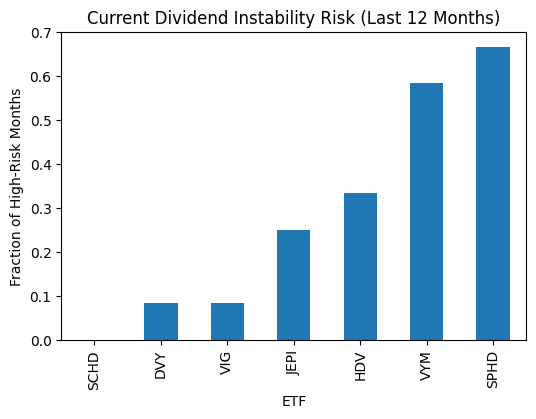

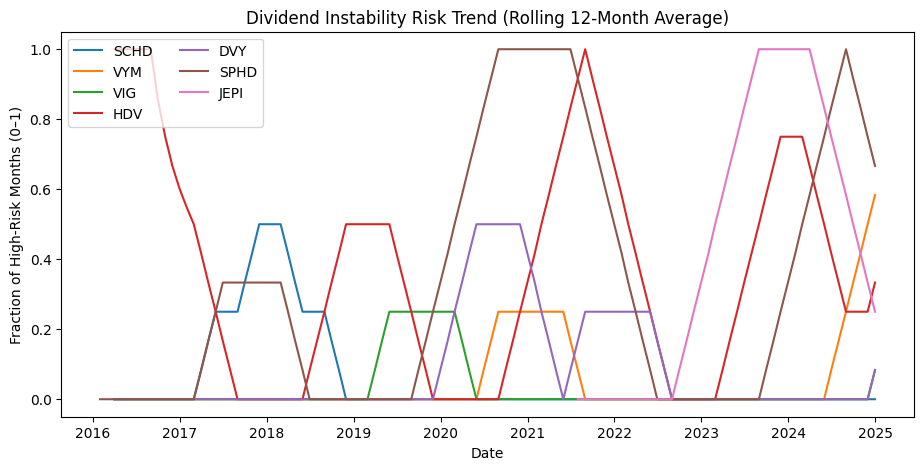

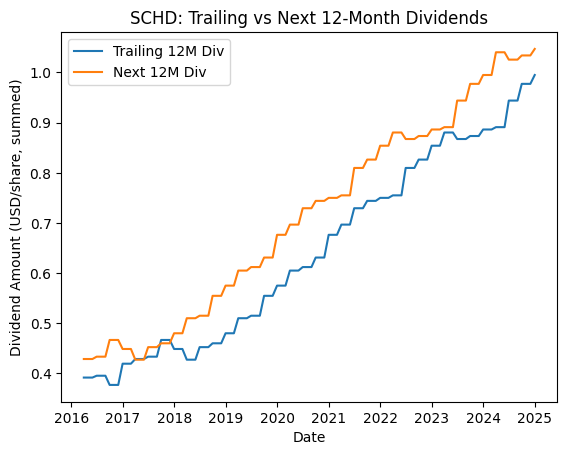

In [ ]:
# Class balance + simple plots

print("Total samples:", len(df))
print(
    df["target_risk"]
    .value_counts(normalize=True)
    .rename("proportion")
)

# Plot: risk label over time by ticker (small overview)
latest = (
    df.sort_values("date")
      .groupby("ticker")
      .tail(12)
      .groupby("ticker")["target_risk"]
      .mean()
      .sort_values()
)

plt.figure(figsize=(6,4))
latest.plot(kind="bar")
plt.title("Current Dividend Instability Risk (Last 12 Months)")
plt.ylabel("Fraction of High-Risk Months")
plt.xlabel("ETF")
plt.show()


#Trendlines
WINDOW = 12

fig, axes = plt.subplots(len(TICKERS), 1, figsize=(10, 2.2 * len(TICKERS)), sharex=True)

for ax, ticker in zip(axes, TICKERS):
    sub = (
        df[df["ticker"] == ticker]
        .sort_values("date")
        .set_index("date")
    )
    risk_trend = sub["target_risk"].rolling(WINDOW, min_periods=1).mean()

    ax.plot(risk_trend.index, risk_trend.values, linewidth=2)
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Risk")
    ax.set_title(ticker, loc="left", fontsize=11)

axes[-1].set_xlabel("Date")
fig.suptitle(f"Dividend Instability Risk Trend (Rolling {WINDOW}-Month Average)", y=0.995)
plt.tight_layout()
plt.show()



# Plot one ETF dividends (trailing vs next) for intuition
example = df[df["ticker"] == TICKERS[0]].copy()

plt.figure()
plt.plot(example["date"], example["trailing_12m_div"], label="Trailing 12M Div")
plt.plot(example["date"], example["next_12m_div"], label="Next 12M Div")
plt.title(f"{TICKERS[0]}: Trailing vs Next 12-Month Dividends")
plt.xlabel("Date")
plt.ylabel("Dividend Amount (USD/share, summed)")
plt.legend()
plt.show()


## Features and Target
We predict `target_risk` using price-based risk metrics + dividend growth proxies.
We use a time-based split to reduce leakage (train on earlier dates, test on later dates).


In [95]:
# Prepare X/y and a time-based split

FEATURES = [
    "vol_60d",
    "max_drawdown_1y",
    "momentum_1y",
    "div_growth_trailing",
    "yield_proxy",
]

X = df[FEATURES].copy()
y = df["target_risk"].astype(int).copy()

# Time-based split: train on <= cutoff, test on > cutoff
cutoff = df["date"].quantile(0.80)  # last 20% of time points for testing
train_mask = df["date"] <= cutoff

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

print("Cutoff date:", cutoff)
print("Train size:", len(X_train), "Test size:", len(X_test))


Cutoff date: 2023-05-31 00:00:00
Train size: 547 Test size: 133


In [96]:
# Train model with logistic LogisticRegression

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

model.fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test, digits=3))


              precision    recall  f1-score   support

           0      0.771     0.880     0.822        92
           1      0.607     0.415     0.493        41

    accuracy                          0.737       133
   macro avg      0.689     0.648     0.658       133
weighted avg      0.721     0.737     0.721       133



ROC AUC: 0.687
Avg Precision (PR AUC): 0.598


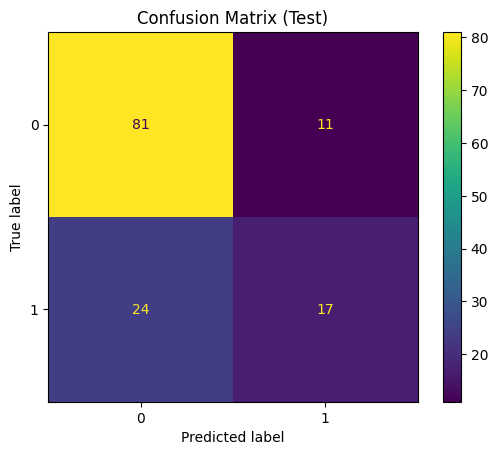

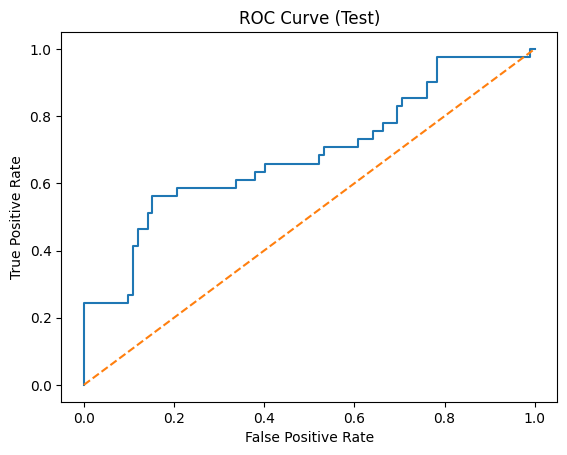

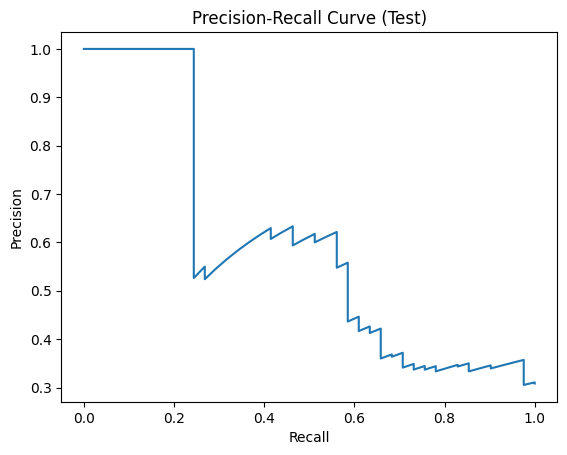

In [97]:
# Evaluation plots (ROC + PR)

roc = roc_auc_score(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

print("ROC AUC:", round(roc, 3))
print("Avg Precision (PR AUC):", round(ap, 3))

# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix (Test)")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec)
plt.title("Precision-Recall Curve (Test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


## Interpretability (SHAP)

We use SHAP values to identify which features most strongly influence the model's risk predictions.
This supports transparency for financial decision-making.

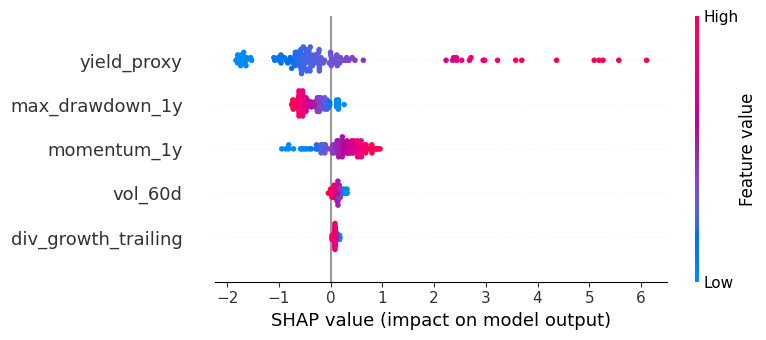

In [98]:
# SHAP for logistic regression (fast + simple)

# Extract the trained logistic regression and scaled data for SHAP
scaler = model.named_steps["scaler"]
clf = model.named_steps["clf"]

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=FEATURES, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=FEATURES, index=X_test.index)

explainer = shap.LinearExplainer(clf, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, show=True)


## Conclusion and Limitations
**Conclusion:** A simple, interpretable classifier can flag dividend ETF payout instability risk using dividend growth and market risk features. SHAP highlights the main drivers behind the predictions.

**Limitations:**
- Small number of ETFs (limited sample size).
- Yahoo Finance metadata varies across tickers/time.
- The “risk” label is a proxy for income stability (dividend decreases vs increases).
